# 使用强化学习逆向设计 MMI 耦合器

本项目旨在使用 `ceviche-challenges` 库，通过强化学习算法逆向设计一个多模干涉 (MMI) 耦合器。

In [1]:
# 安装依赖包（GPU 版本）
!pip install ceviche_challenges
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# 检查 GPU 是否可用
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.2/129.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.6 MB/s eta 0:00:00
  Created wheel for pyMKL: filename=pyMKL-0.0.3-py3-none-any.whl size=6743 sha256=281ac5812f3d781f00dbb568ae7b14419f0087947d18f0a4d781ef0821fdbbbd
  Stored in directory: /root/.cache/pip/wheels/ff/49/54/a83bd5cbd97b514920ab460921635ca4d98b9e5a7b2f26329e
Successfully built pyMKL
Looking in indexes: https://download.pytorch.org/whl/cu118
CUDA Available: True
GPU Device: Tesla T4


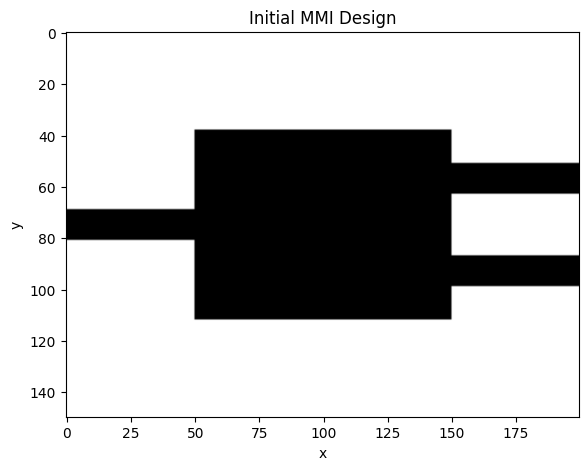

In [2]:
import numpy as np
import matplotlib.pylab as plt

import ceviche
from ceviche import fdfd_ez, jacobian
from ceviche.modes import insert_mode

# 定义仿真参数
wavelength = 1.55e-6
omega = 2 * np.pi * ceviche.constants.C_0 / wavelength
dl = 40e-9
npml = 20
nx, ny = 200, 150
epsr_background = 1.0**2 # 背景折射率 (空气)
epsr_si = 3.45**2      # 硅的折射率

# 定义 MMI 结构
epsr = np.ones((nx, ny)) * epsr_background

# 输入/输出波导宽度
wg_width_cells = int(0.5e-6 / dl)

# 输入波导
input_wg_y_start = ny // 2 - wg_width_cells // 2
input_wg_y_end = ny // 2 + wg_width_cells // 2
epsr[0:nx//4, input_wg_y_start:input_wg_y_end] = epsr_si

# MMI body (设计区域)
mmi_x_start = nx // 4
mmi_x_end = 3 * nx // 4
mmi_y_start = ny // 2 - int(3e-6 / dl) // 2
mmi_y_end = ny // 2 + int(3e-6 / dl) // 2
epsr[mmi_x_start:mmi_x_end, mmi_y_start:mmi_y_end] = epsr_si

# 输出波导 1
output_wg1_y_start = ny // 2 - int(1.5e-6 / dl) // 2 - wg_width_cells // 2
output_wg1_y_end = ny // 2 - int(1.5e-6 / dl) // 2 + wg_width_cells // 2
epsr[3*nx//4:, output_wg1_y_start:output_wg1_y_end] = epsr_si

# 输出波导 2
output_wg2_y_start = ny // 2 + int(1.5e-6 / dl) // 2 - wg_width_cells // 2
output_wg2_y_end = ny // 2 + int(1.5e-6 / dl) // 2 + wg_width_cells // 2
epsr[3*nx//4:, output_wg2_y_start:output_wg2_y_end] = epsr_si

# 创建仿真对象
F = fdfd_ez(omega, dl, epsr, npml=[npml, npml])

# 可视化初始结构
plt.figure(figsize=(10, 5))
plt.imshow(np.sqrt(epsr.T), cmap='Greys')
plt.title('Initial MMI Design')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


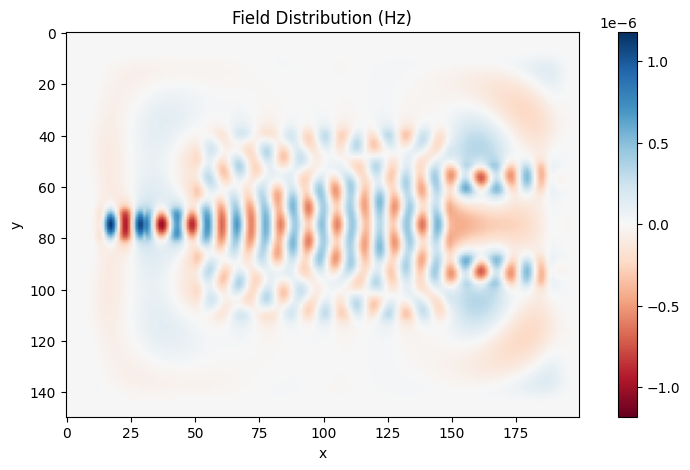

Initial Transmission to Port 1: 0.5000
Initial Transmission to Port 2: 0.5000
Total Power (normalized): 1.0


In [3]:
# 定义光源和监视器
source_pos_x = npml + 10
mode_pos_y_center = ny // 2
mode_pos_y_range = np.arange(mode_pos_y_center - wg_width_cells//2, mode_pos_y_center + wg_width_cells//2)

# 注入模式光源
source = insert_mode(omega, dl, source_pos_x, mode_pos_y_range, epsr, npml=npml, m=1)

# 定义监视器
monitor_output1_pos_x = nx - npml - 10
monitor_output1_pos_y = ny // 2 - int(1.5e-6 / dl) // 2

monitor_output2_pos_x = nx - npml - 10
monitor_output2_pos_y = ny // 2 + int(1.5e-6 / dl) // 2

# 运行仿真
Ex, Ey, Hz = F.solve(source)

# 可视化场分布
plt.figure(figsize=(10, 5))
plt.imshow(np.real(Hz).T, cmap='RdBu', vmin=-np.max(np.abs(Hz)), vmax=np.max(np.abs(Hz)))
plt.title('Field Distribution (Hz)')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

# 计算初始性能（使用场幅度作为近似）
# 在输出端口位置计算场强度
power_out1 = np.sum(np.abs(Hz[monitor_output1_pos_x, output_wg1_y_start:output_wg1_y_end])**2)
power_out2 = np.sum(np.abs(Hz[monitor_output2_pos_x, output_wg2_y_start:output_wg2_y_end])**2)
total_power = power_out1 + power_out2

print(f"Initial Transmission to Port 1: {power_out1 / total_power:.4f}")
print(f"Initial Transmission to Port 2: {power_out2 / total_power:.4f}")
print(f"Total Power (normalized): 1.0")


In [9]:
import gymnasium as gym
from gymnasium import spaces

class MMIEnv(gym.Env):
    def __init__(self, F, epsr_background, epsr_si, mmi_x_start, mmi_x_end, mmi_y_start, mmi_y_end):
        super(MMIEnv, self).__init__()
        
        self.F = F
        self.epsr_background = epsr_background
        self.epsr_si = epsr_si
        
        self.mmi_x_start = mmi_x_start
        self.mmi_x_end = mmi_x_end
        self.mmi_y_start = mmi_y_start
        self.mmi_y_end = mmi_y_end
        
        self.design_shape = (mmi_x_end - mmi_x_start, mmi_y_end - mmi_y_start)
        
        # 动作空间: 离散，大小为设计区域的像素点个数。每个动作代表翻转一个像素。
        self.action_space = spaces.Discrete(self.design_shape[0] * self.design_shape[1])
        
        # 状态空间: Box，代表设计区域的像素值 (0 或 1)
        self.observation_space = spaces.Box(low=0, high=1, shape=self.design_shape, dtype=np.uint8)
        
        self.epsr_init = self._create_initial_epsr()
        self.state = self.epsr_init[self.mmi_x_start:self.mmi_x_end, self.mmi_y_start:self.mmi_y_end]

    def _create_initial_epsr(self):
        # 与之前定义结构的代码类似
        epsr = np.ones((nx, ny)) * self.epsr_background
        wg_width_cells = int(0.5e-6 / dl)
        input_wg_y_start = ny // 2 - wg_width_cells // 2
        input_wg_y_end = ny // 2 + wg_width_cells // 2
        epsr[0:self.mmi_x_start, input_wg_y_start:input_wg_y_end] = self.epsr_si
        epsr[self.mmi_x_start:self.mmi_x_end, self.mmi_y_start:self.mmi_y_end] = self.epsr_si
        output_wg1_y_start = ny // 2 - int(1.5e-6 / dl) // 2 - wg_width_cells // 2
        output_wg1_y_end = ny // 2 - int(1.5e-6 / dl) // 2 + wg_width_cells // 2
        epsr[self.mmi_x_end:, output_wg1_y_start:output_wg1_y_end] = self.epsr_si
        output_wg2_y_start = ny // 2 + int(1.5e-6 / dl) // 2 - wg_width_cells // 2
        output_wg2_y_end = ny // 2 + int(1.5e-6 / dl) // 2 + wg_width_cells // 2
        epsr[self.mmi_x_end:, output_wg2_y_start:output_wg2_y_end] = self.epsr_si
        return epsr

    def step(self, action):
        # 将一维的 action 转换为二维坐标
        x, y = np.unravel_index(action, self.design_shape)
        
        # 翻转像素值
        self.state[x, y] = self.epsr_si if self.state[x, y] == self.epsr_background else self.epsr_background
        
        # 构建完整的 epsr
        epsr_full = self.epsr_init.copy()
        epsr_full[self.mmi_x_start:self.mmi_x_end, self.mmi_y_start:self.mmi_y_end] = self.state

        # 更新 FDFD 对象的介电常数
        self.F.eps_r = epsr_full
        
        # 运行仿真
        wg_width_cells = int(0.5e-6 / dl)
        mode_y_range = np.arange(ny//2 - wg_width_cells//2, ny//2 + wg_width_cells//2)
        source = insert_mode(omega, dl, npml + 10, mode_y_range, epsr_full, npml=npml, m=1)
        Ex, Ey, Hz = self.F.solve(source)
        
        # 计算性能（使用场幅度作为近似）
        output_wg1_y_start = ny // 2 - int(1.5e-6 / dl) // 2 - wg_width_cells // 2
        output_wg1_y_end = ny // 2 - int(1.5e-6 / dl) // 2 + wg_width_cells // 2
        output_wg2_y_start = ny // 2 + int(1.5e-6 / dl) // 2 - wg_width_cells // 2
        output_wg2_y_end = ny // 2 + int(1.5e-6 / dl) // 2 + wg_width_cells // 2
        
        power_out1 = np.sum(np.abs(Hz[nx - npml - 10, output_wg1_y_start:output_wg1_y_end])**2)
        power_out2 = np.sum(np.abs(Hz[nx - npml - 10, output_wg2_y_start:output_wg2_y_end])**2)
        total_power = power_out1 + power_out2 + 1e-10  # 添加小常数避免除以零

        T1 = power_out1 / total_power
        T2 = power_out2 / total_power
        
        # 奖励函数
        reward = (T1 + T2) - 10 * np.abs(T1 - T2)
        
        terminated = False # 在这个简单版本中，我们让它一直运行
        truncated = False
        
        return self.state.copy(), reward, terminated, truncated, {}

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.epsr_init = self._create_initial_epsr()
        self.state = self.epsr_init[self.mmi_x_start:self.mmi_x_end, self.mmi_y_start:self.mmi_y_end]
        return self.state.copy(), {}

    def render(self, mode='human'):
        plt.figure(figsize=(10, 5))
        plt.imshow(np.sqrt(self.state.T), cmap='Greys')
        plt.title('Current MMI Design')
        plt.show()


# 实例化环境
env = MMIEnv(F, epsr_background, epsr_si, mmi_x_start, mmi_x_end, mmi_y_start, mmi_y_end)

In [ ]:
!pip install stable-baselines3 shimmy gymnasium

Dependencies already installed with GPU support


In [2]:
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import torch
from IPython.display import clear_output

# 检测并设置设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# 包装环境
vec_env = DummyVecEnv([lambda: env])

# 定义增强的回调函数用于记录训练过程
class AdvancedTrainingCallback(BaseCallback):
    def __init__(self, check_freq=50, save_design_freq=200, verbose=1):
        super(AdvancedTrainingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_design_freq = save_design_freq
        self.rewards = []
        self.timesteps = []
        self.episode_rewards = []  # 记录每个episode的奖励
        self.design_history = []
        self.design_timesteps = []
        self.last_episode_reward = 0
        
    def _on_step(self):
        # 记录当前episode的累积奖励
        if hasattr(self.model.env, 'buf_rews'):
            # 获取当前累积奖励
            current_reward = np.mean(self.model.env.buf_rews)
            self.episode_rewards.append(current_reward)
        
        # 周期性记录训练指标
        if self.n_calls % self.check_freq == 0:
            # 使用episode_rewards计算平均奖励
            if len(self.episode_rewards) > 0:
                mean_reward = np.mean(self.episode_rewards[-self.check_freq:]) if len(self.episode_rewards) >= self.check_freq else np.mean(self.episode_rewards)
                self.rewards.append(mean_reward)
                self.timesteps.append(self.num_timesteps)
                print(f"Step {self.num_timesteps}: Mean Reward = {mean_reward:.4f}")
        
        # 周期性保存设计状态
        if self.n_calls % self.save_design_freq == 0:
            current_design = env.state.copy()
            self.design_history.append(current_design)
            self.design_timesteps.append(self.num_timesteps)
            
            # 实时更新训练进度可视化
            if len(self.rewards) > 0:
                clear_output(wait=True)
                fig, axes = plt.subplots(1, 2, figsize=(15, 4))
                
                # 奖励曲线
                axes[0].plot(self.timesteps, self.rewards, 'b-', alpha=0.6, linewidth=2, label='Mean Reward')
                if len(self.rewards) > 5:
                    window = min(5, len(self.rewards) // 3)
                    smoothed = np.convolve(self.rewards, np.ones(window)/window, mode='valid')
                    axes[0].plot(self.timesteps[:len(smoothed)], smoothed, 'r-', linewidth=2.5, label='Smoothed')
                axes[0].set_xlabel('Timesteps')
                axes[0].set_ylabel('Mean Reward')
                axes[0].set_title('Training Progress')
                axes[0].legend()
                axes[0].grid(True, alpha=0.3)
                
                # 当前设计
                axes[1].imshow(np.sqrt(current_design.T), cmap='Greys', aspect='auto')
                axes[1].set_title(f'Current Design (Step {self.num_timesteps})')
                axes[1].set_xlabel('x')
                axes[1].set_ylabel('y')
                
                plt.tight_layout()
                plt.show()
        
        return True

# 创建回调对象
callback = AdvancedTrainingCallback(check_freq=50, save_design_freq=200)

# 创建 DQN 模型（使用 GPU）
model = DQN('MlpPolicy', vec_env, verbose=0, buffer_size=5000, learning_starts=100, 
            batch_size=32, train_freq=4, target_update_interval=250, device=device)

# 训练模型
print("=" * 60)
print("开始训练 - 实时可视化训练过程")
print("=" * 60)
model.learn(total_timesteps=2000, callback=callback)
print("\n" + "=" * 60)
print("训练完成！")
print("=" * 60)

# 绘制训练曲线
if len(callback.rewards) > 0:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(callback.timesteps, callback.rewards, marker='o', linewidth=2)
    plt.xlabel('Timesteps')
    plt.ylabel('Mean Reward')
    plt.title('Training Progress: Reward vs Timesteps')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    if len(callback.rewards) > 5:
        # 使用移动平均平滑曲线
        window = min(5, len(callback.rewards) // 3)
        smoothed = np.convolve(callback.rewards, np.ones(window)/window, mode='valid')
        plt.plot(callback.timesteps[:len(smoothed)], smoothed, 'r-', linewidth=2.5, label='Smoothed')
        plt.plot(callback.timesteps, callback.rewards, 'b-', alpha=0.5, linewidth=1, label='Raw')
        plt.legend()
    else:
        plt.plot(callback.timesteps, callback.rewards, marker='o', linewidth=2)
    plt.xlabel('Timesteps')
    plt.ylabel('Mean Reward')
    plt.title('Training Progress (Smoothed)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n训练统计:")
    print(f"  记录的检查点数: {len(callback.rewards)}")
    print(f"  平均奖励范围: [{min(callback.rewards):.4f}, {max(callback.rewards):.4f}]")
    print(f"  最终平均奖励: {callback.rewards[-1]:.4f}")
else:
    print("警告：未能记录训练数据")

# 训练结束后，获取优化后的设计
obs = vec_env.reset()
optimized_design = env.state

# 可视化最终设计
plt.figure(figsize=(10, 5))
plt.imshow(np.sqrt(optimized_design.T), cmap='Greys')
plt.title('Optimized MMI Design')
plt.show()

# 评估最终性能
epsr_final = env.epsr_init.copy()
epsr_final[mmi_x_start:mmi_x_end, mmi_y_start:mmi_y_end] = optimized_design

mode_y_range = np.arange(ny//2 - wg_width_cells//2, ny//2 + wg_width_cells//2)
source = insert_mode(omega, dl, npml + 10, mode_y_range, epsr_final, npml=npml, m=1)
Ex, Ey, Hz = F.solve(source)

# 计算最终性能（使用场幅度作为近似）
power_out1 = np.sum(np.abs(Hz[nx - npml - 10, output_wg1_y_start:output_wg1_y_end])**2)
power_out2 = np.sum(np.abs(Hz[nx - npml - 10, output_wg2_y_start:output_wg2_y_end])**2)
total_power = power_out1 + power_out2

T1_final = power_out1 / total_power
T2_final = power_out2 / total_power

print(f"Final Transmission to Port 1: {T1_final}")
print(f"Final Transmission to Port 2: {T2_final}")
print(f"Total Transmission: {T1_final + T2_final}")
print(f"Splitting Imbalance: {np.abs(T1_final - T2_final)}")

ModuleNotFoundError: No module named 'stable_baselines3'

In [ ]:
# ==================== 训练结果总结与可视化 ====================

print("\n" + "=" * 60)
print("训练结果分析")
print("=" * 60)

# 1. 绘制完整的训练曲线
fig = plt.figure(figsize=(16, 10))

# 奖励变化
ax1 = plt.subplot(2, 3, 1)
if len(callback.rewards) > 0:
    ax1.plot(callback.timesteps, callback.rewards, 'b-', alpha=0.4, linewidth=1, label='Raw')
    if len(callback.rewards) > 10:
        window = max(3, len(callback.rewards) // 10)
        smoothed = np.convolve(callback.rewards, np.ones(window)/window, mode='valid')
        ax1.plot(callback.timesteps[:len(smoothed)], smoothed, 'r-', linewidth=2.5, label='Smoothed')
    ax1.set_xlabel('Timesteps', fontsize=11)
    ax1.set_ylabel('Mean Reward', fontsize=11)
    ax1.set_title('Training Reward Curve', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# 2. 设计演化历史
if len(callback.design_history) > 0:
    n_designs = len(callback.design_history)
    indices = [0, n_designs//3, 2*n_designs//3, -1]  # 显示4个关键时刻
    
    for i, idx in enumerate(indices):
        ax = plt.subplot(2, 3, i+2)
        design = callback.design_history[idx]
        timestep = callback.design_timesteps[idx]
        ax.imshow(np.sqrt(design.T), cmap='Greys', aspect='auto')
        ax.set_title(f'Design at Step {timestep}', fontsize=10)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

# 3. 设计演化动画（显示多个中间状态）
if len(callback.design_history) > 1:
    n_snapshots = min(8, len(callback.design_history))
    step = max(1, len(callback.design_history) // n_snapshots)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(n_snapshots):
        idx = i * step
        if idx >= len(callback.design_history):
            idx = -1
        design = callback.design_history[idx]
        timestep = callback.design_timesteps[idx]
        
        axes[i].imshow(np.sqrt(design.T), cmap='Greys', aspect='auto')
        axes[i].set_title(f'Step {timestep}', fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle('Design Evolution During Training', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n✓ 训练过程可视化完成")

: 

In [ ]:
# ==================== 最终设计评估与对比 ====================

print("\n" + "=" * 60)
print("最终设计评估")
print("=" * 60)

# 获取优化后的设计
obs = vec_env.reset()
optimized_design = env.state

# 创建初始设计用于对比
initial_design = np.ones((mmi_x_end - mmi_x_start, mmi_y_end - mmi_y_start)) * epsr_si

# 设计对比可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 初始设计（完整结构）
initial_epsr_full = np.ones((nx, ny)) * epsr_background
initial_epsr_full[0:nx//4, input_wg_y_start:input_wg_y_end] = epsr_si
initial_epsr_full[mmi_x_start:mmi_x_end, mmi_y_start:mmi_y_end] = epsr_si
initial_epsr_full[3*nx//4:, output_wg1_y_start:output_wg1_y_end] = epsr_si
initial_epsr_full[3*nx//4:, output_wg2_y_start:output_wg2_y_end] = epsr_si

axes[0].imshow(np.sqrt(initial_epsr_full.T), cmap='Greys', aspect='auto')
axes[0].set_title('Initial Design (Baseline)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# 优化后的设计（完整结构）
epsr_final = env.epsr_init.copy()
epsr_final[mmi_x_start:mmi_x_end, mmi_y_start:mmi_y_end] = optimized_design

axes[1].imshow(np.sqrt(epsr_final.T), cmap='Greys', aspect='auto')
axes[1].set_title('Optimized Design (After RL)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

# 设计区域的变化
difference = np.abs(optimized_design - initial_design)
im = axes[2].imshow(difference.T, cmap='hot', aspect='auto')
axes[2].set_title('Design Changes (Heatmap)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('x (design region)')
axes[2].set_ylabel('y (design region)')
plt.colorbar(im, ax=axes[2], label='Change magnitude')

plt.tight_layout()
plt.show()

print(f"\n设计区域尺寸: {optimized_design.shape}")
print(f"修改的像素数: {np.sum(difference > 0)}")
print(f"修改比例: {np.sum(difference > 0) / difference.size * 100:.2f}%")

In [ ]:
# ==================== 电磁场仿真与性能评估 ====================

print("\n" + "=" * 60)
print("电磁场仿真与性能对比")
print("=" * 60)

# 仿真优化后的设计
mode_y_range = np.arange(ny//2 - wg_width_cells//2, ny//2 + wg_width_cells//2)
source = insert_mode(omega, dl, npml + 10, mode_y_range, epsr_final, npml=npml, m=1)
Ex_opt, Ey_opt, Hz_opt = F.solve(source)

# 仿真初始设计（用于对比）
F_init = fdfd_ez(omega, dl, initial_epsr_full, npml=[npml, npml])
source_init = insert_mode(omega, dl, npml + 10, mode_y_range, initial_epsr_full, npml=npml, m=1)
Ex_init, Ey_init, Hz_init = F_init.solve(source_init)

# 场分布对比可视化
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 第一行：初始设计的场分布
im1 = axes[0, 0].imshow(np.real(Hz_init).T, cmap='RdBu', 
                         vmin=-np.max(np.abs(Hz_init)), vmax=np.max(np.abs(Hz_init)))
axes[0, 0].set_title('Initial: Re(Hz)', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(np.abs(Hz_init).T, cmap='hot')
axes[0, 1].set_title('Initial: |Hz|', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')
plt.colorbar(im2, ax=axes[0, 1])

im3 = axes[0, 2].imshow(np.log10(np.abs(Hz_init).T + 1e-10), cmap='viridis')
axes[0, 2].set_title('Initial: log10(|Hz|)', fontsize=11, fontweight='bold')
axes[0, 2].set_xlabel('x')
axes[0, 2].set_ylabel('y')
plt.colorbar(im3, ax=axes[0, 2])

# 第二行：优化设计的场分布
im4 = axes[1, 0].imshow(np.real(Hz_opt).T, cmap='RdBu',
                         vmin=-np.max(np.abs(Hz_opt)), vmax=np.max(np.abs(Hz_opt)))
axes[1, 0].set_title('Optimized: Re(Hz)', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
plt.colorbar(im4, ax=axes[1, 0])

im5 = axes[1, 1].imshow(np.abs(Hz_opt).T, cmap='hot')
axes[1, 1].set_title('Optimized: |Hz|', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('y')
plt.colorbar(im5, ax=axes[1, 1])

im6 = axes[1, 2].imshow(np.log10(np.abs(Hz_opt).T + 1e-10), cmap='viridis')
axes[1, 2].set_title('Optimized: log10(|Hz|)', fontsize=11, fontweight='bold')
axes[1, 2].set_xlabel('x')
axes[1, 2].set_ylabel('y')
plt.colorbar(im6, ax=axes[1, 2])

plt.tight_layout()
plt.show()

# 计算性能指标
# 初始设计
power_out1_init = np.sum(np.abs(Hz_init[nx - npml - 10, output_wg1_y_start:output_wg1_y_end])**2)
power_out2_init = np.sum(np.abs(Hz_init[nx - npml - 10, output_wg2_y_start:output_wg2_y_end])**2)
total_power_init = power_out1_init + power_out2_init
T1_init = power_out1_init / total_power_init
T2_init = power_out2_init / total_power_init

# 优化设计
power_out1_opt = np.sum(np.abs(Hz_opt[nx - npml - 10, output_wg1_y_start:output_wg1_y_end])**2)
power_out2_opt = np.sum(np.abs(Hz_opt[nx - npml - 10, output_wg2_y_start:output_wg2_y_end])**2)
total_power_opt = power_out1_opt + power_out2_opt
T1_opt = power_out1_opt / total_power_opt
T2_opt = power_out2_opt / total_power_opt

# 性能对比表格
print("\n" + "=" * 60)
print("性能对比结果")
print("=" * 60)
print(f"\n{'指标':<25} {'初始设计':<15} {'优化设计':<15} {'改进':<15}")
print("-" * 70)
print(f"{'Port 1 传输率':<25} {T1_init:<15.4f} {T1_opt:<15.4f} {(T1_opt-T1_init):<+15.4f}")
print(f"{'Port 2 传输率':<25} {T2_init:<15.4f} {T2_opt:<15.4f} {(T2_opt-T2_init):<+15.4f}")
print(f"{'总传输率':<25} {T1_init+T2_init:<15.4f} {T1_opt+T2_opt:<15.4f} {(T1_opt+T2_opt-T1_init-T2_init):<+15.4f}")
print(f"{'分光不平衡度':<25} {np.abs(T1_init-T2_init):<15.4f} {np.abs(T1_opt-T2_opt):<15.4f} {(np.abs(T1_opt-T2_opt)-np.abs(T1_init-T2_init)):<+15.4f}")
print(f"{'分光比 (Port1/Port2)':<25} {T1_init/T2_init:<15.4f} {T1_opt/T2_opt:<15.4f} {'—':<15}")
print("-" * 70)

# 性能提升可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 传输率对比
categories = ['Port 1', 'Port 2', 'Total']
initial_vals = [T1_init, T2_init, T1_init+T2_init]
optimized_vals = [T1_opt, T2_opt, T1_opt+T2_opt]

x = np.arange(len(categories))
width = 0.35

axes[0].bar(x - width/2, initial_vals, width, label='Initial', alpha=0.8, color='skyblue')
axes[0].bar(x + width/2, optimized_vals, width, label='Optimized', alpha=0.8, color='coral')
axes[0].set_xlabel('Output Port', fontsize=11)
axes[0].set_ylabel('Transmission', fontsize=11)
axes[0].set_title('Transmission Comparison', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# 分光平衡性
balance_data = [np.abs(T1_init - T2_init), np.abs(T1_opt - T2_opt)]
axes[1].bar(['Initial', 'Optimized'], balance_data, color=['skyblue', 'coral'], alpha=0.8)
axes[1].set_ylabel('Splitting Imbalance |T1-T2|', fontsize=11)
axes[1].set_title('Splitting Balance (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ 完整训练与评估流程完成！")